# Import Libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import f1_score, classification_report
import sys
import os
from datetime import datetime
import pandas as pd

sys.path.append(os.path.abspath('../'))
from CNN.CNNFromScratch import CNNFromScratch

In [ ]:
# Set random seeds untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

# Load Dataset

Loading CIFAR-10 dataset...
Training data shape: (40000, 32, 32, 3)
Training labels shape: (40000,)
Validation data shape: (10000, 32, 32, 3)
Validation labels shape: (10000,)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000,)


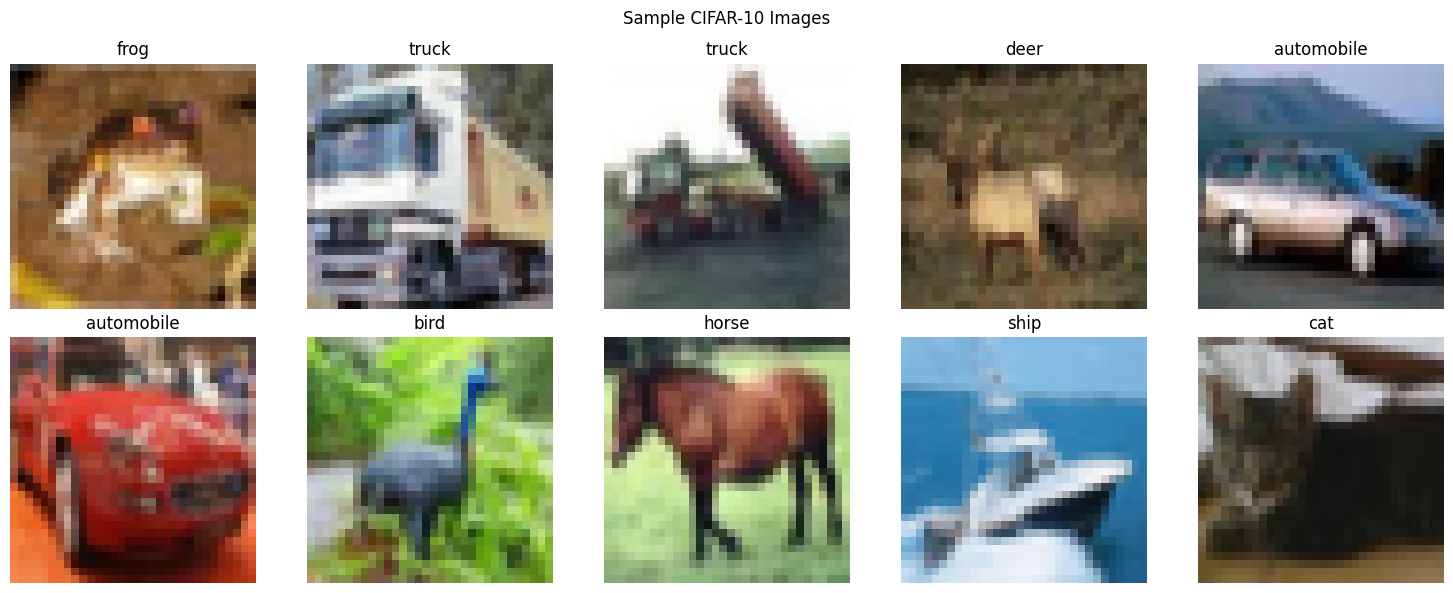

In [7]:
def load_cifar10():
    print("Loading CIFAR-10 dataset...")
    (x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()
    
    x_train_full = x_train_full.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    
    y_train_full = y_train_full.flatten()
    y_test = y_test.flatten()
    
    n_train = 40000
    x_train = x_train_full[:n_train]
    y_train = y_train_full[:n_train]
    x_val = x_train_full[n_train:]
    y_val = y_train_full[n_train:]
    
    print(f"Training data shape: {x_train.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Validation data shape: {x_val.shape}")
    print(f"Validation labels shape: {y_val.shape}")
    print(f"Test data shape: {x_test.shape}")
    print(f"Test labels shape: {y_test.shape}")
    
    return x_train, y_train, x_val, y_val, x_test, y_test

def show_samples(x, y, num_samples=10):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    
    plt.figure(figsize=(15, 6))
    for i in range(num_samples):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.title(f'{class_names[y[i]]}')
        plt.axis('off')
    plt.suptitle('Sample CIFAR-10 Images')
    plt.tight_layout()
    plt.show()

# Load dataset
x_train, y_train, x_val, y_val, x_test, y_test = load_cifar10()
show_samples(x_train, y_train)

# CNN Experiment Class

In [8]:
class CNNExperiments:
    def __init__(self, x_train, y_train, x_val, y_val, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.x_test = x_test
        self.y_test = y_test
        
        self.results = {}
        self.save_dir = "cnn_experiments"
        os.makedirs(self.save_dir, exist_ok=True)
    
    def create_base_model(self, conv_layers=2, filters_per_layer=[32, 64], 
                         kernel_sizes=[(3,3), (3,3)], pooling_type='max'):
        """Membuat model CNN dengan konfigurasi yang diberikan"""
        model = keras.Sequential([
            keras.layers.Input(shape=(32, 32, 3))
        ])
        
        for i in range(conv_layers):
            filters = filters_per_layer[i] if i < len(filters_per_layer) else filters_per_layer[-1]
            kernel_size = kernel_sizes[i] if i < len(kernel_sizes) else kernel_sizes[-1]
            
            model.add(keras.layers.Conv2D(
                filters=filters,
                kernel_size=kernel_size,
                activation='relu',
                padding='same'
            ))
            
            if pooling_type == 'max':
                model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
            else:
                model.add(keras.layers.AveragePooling2D(pool_size=(2, 2)))
        
        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(128, activation='relu'))
        model.add(keras.layers.Dropout(0.5))
        model.add(keras.layers.Dense(10, activation='softmax'))
        
        return model
    
    def train_model(self, model, model_name, epochs=10, verbose=1):
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        if verbose:
            print(f"\n{'='*50}")
            print(f"Training {model_name}")
            print(f"{'='*50}")
            model.summary()
        
        history = model.fit(
            self.x_train, self.y_train,
            batch_size=32,
            epochs=epochs,
            validation_data=(self.x_val, self.y_val),
            verbose=verbose
        )
        
        test_loss, test_acc = model.evaluate(self.x_test, self.y_test, verbose=0)
        y_pred = model.predict(self.x_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        f1_macro = f1_score(self.y_test, y_pred_classes, average='macro')
        
        result = {
            'model': model,
            'history': history.history,
            'test_accuracy': test_acc,
            'test_loss': test_loss,
            'f1_macro': f1_macro,
            'predictions': y_pred_classes
        }
        
        self.results[model_name] = result
        
        if verbose:
            print(f"Test Accuracy: {test_acc:.4f}")
            print(f"Test Loss: {test_loss:.4f}")
            print(f"F1-Macro Score: {f1_macro:.4f}")
        
        return result
    
    def plot_training_history(self, model_names, metric='loss'):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 2, 1)
        for name in model_names:
            if name in self.results:
                plt.plot(self.results[name]['history'][metric], label=f'{name} (train)')
        plt.title(f'Training {metric.title()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.title())
        plt.legend()
        plt.grid(True)
        
        plt.subplot(1, 2, 2)
        for name in model_names:
            if name in self.results:
                plt.plot(self.results[name]['history'][f'val_{metric}'], label=f'{name} (val)')
        plt.title(f'Validation {metric.title()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.title())
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def compare_results(self, model_names):
        comparison_data = []
        
        for name in model_names:
            if name in self.results:
                result = self.results[name]
                comparison_data.append({
                    'Model': name,
                    'Test Accuracy': result['test_accuracy'],
                    'Test Loss': result['test_loss'],
                    'F1-Macro': result['f1_macro']
                })
        
        df = pd.DataFrame(comparison_data)
        print("\n" + "="*60)
        print("COMPARISON RESULTS")
        print("="*60)
        print(df.to_string(index=False, float_format='%.4f'))
        print("="*60)
        
        return df

experiments = CNNExperiments(x_train, y_train, x_val, y_val, x_test, y_test)

# 1. Pengaruh jumlah layer konvolusi

EKSPERIMEN 1: PENGARUH JUMLAH LAYER KONVOLUSI

Training 1_Conv_Layer


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,050,890 (4.01 MB)

 Trainable params: 1,050,890 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 39ms/step - accuracy: 0.2042 - loss: 2.0894 - val_accuracy: 0.4384 - val_loss: 1.6571
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.3282 - loss: 1.7596 - val_accuracy: 0.4723 - val_loss: 1.4770
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 44s 35ms/step - accuracy: 0.3836 - loss: 1.6336 - val_accuracy: 0.5004 - val_loss: 1.4208
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step - accuracy: 0.4034 - loss: 1.5772 - val_accuracy: 0.5332 - val_loss: 1.3699
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 58s 46ms/step - accuracy: 0.4179 - loss: 1.5299 - val_accuracy: 0.5494 - val_loss: 1.2858
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 46s 37ms/step - accuracy: 0.4390 - loss: 1.4911 - val_accuracy: 0.5427 - val_loss: 1.3170
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 50s 40ms/step - accuracy: 0.4512 - loss: 1.4589 - val_accuracy: 0.5669 - val_loss: 1.2689
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.4615 -

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 66s 49ms/step - accuracy: 0.3162 - loss: 1.8570 - val_accuracy: 0.5636 - val_loss: 1.2465
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.5177 - loss: 1.3345 - val_accuracy: 0.6269 - val_loss: 1.0961
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.5829 - loss: 1.1772 - val_accuracy: 0.6470 - val_loss: 1.0302
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.6179 - loss: 1.0743 - val_accuracy: 0.6584 - val_loss: 0.9694
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.6400 - loss: 1.0139 - val_accuracy: 0.6783 - val_loss: 0.9291
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.6631 - loss: 0.9561 - val_accuracy: 0.6919 - val_loss: 0.8970
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.6826 - loss: 0.8909 - val_accuracy: 0.6961 - val_loss: 0.8885
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 43s 34ms/step - accuracy: 0.6952 -

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 28ms/step - accuracy: 0.3048 - loss: 1.8631 - val_accuracy: 0.5599 - val_loss: 1.2292
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.5411 - loss: 1.2865 - val_accuracy: 0.6368 - val_loss: 1.0247
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 33s 26ms/step - accuracy: 0.6222 - loss: 1.0771 - val_accuracy: 0.6656 - val_loss: 0.9670
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6624 - loss: 0.9674 - val_accuracy: 0.6997 - val_loss: 0.8690
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6995 - loss: 0.8635 - val_accuracy: 0.7087 - val_loss: 0.8410
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - accuracy: 0.7202 - loss: 0.7977 - val_accuracy: 0.7127 - val_loss: 0.8410
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.7431 - loss: 0.7326 - val_accuracy: 0.7245 - val_loss: 0.7947
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.7612 -

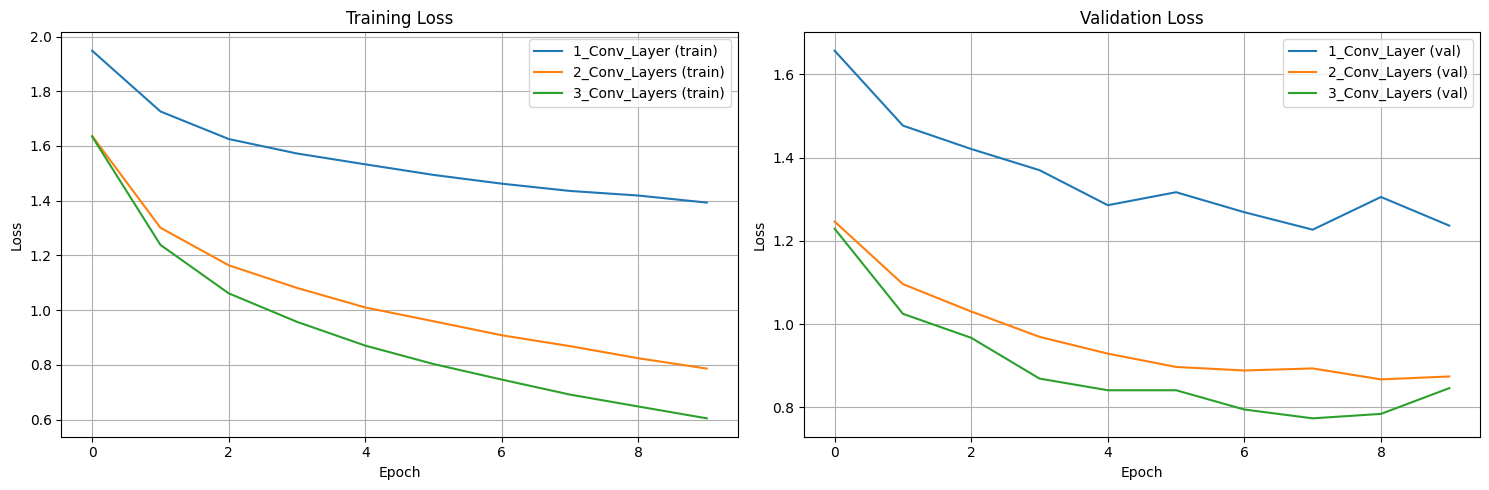


COMPARISON RESULTS
        Model  Test Accuracy  Test Loss  F1-Macro
 1_Conv_Layer         0.5727     1.2411    0.5655
2_Conv_Layers         0.6968     0.8760    0.6965
3_Conv_Layers         0.7177     0.8765    0.7143


,Model,Test Accuracy,Test Loss,F1-Macro
0,1_Conv_Layer,0.5727,1.241112,0.565526
1,2_Conv_Layers,0.6968,0.875953,0.696530
2,3_Conv_Layers,0.7177,0.876526,0.714252


In [9]:
print("="*80)
print("EKSPERIMEN 1: PENGARUH JUMLAH LAYER KONVOLUSI")
print("="*80)

# Model dengan 1 conv layer
model_1conv = experiments.create_base_model(
    conv_layers=1, 
    filters_per_layer=[32], 
    kernel_sizes=[(3,3)]
)
experiments.train_model(model_1conv, "1_Conv_Layer", epochs=10)

# Model dengan 2 conv layers
model_2conv = experiments.create_base_model(
    conv_layers=2, 
    filters_per_layer=[32, 64], 
    kernel_sizes=[(3,3), (3,3)]
)
experiments.train_model(model_2conv, "2_Conv_Layers", epochs=10)

# Model dengan 3 conv layers
model_3conv = experiments.create_base_model(
    conv_layers=3, 
    filters_per_layer=[32, 64, 128], 
    kernel_sizes=[(3,3), (3,3), (3,3)]
)
experiments.train_model(model_3conv, "3_Conv_Layers", epochs=10)

experiments.plot_training_history(["1_Conv_Layer", "2_Conv_Layers", "3_Conv_Layers"])
experiments.compare_results(["1_Conv_Layer", "2_Conv_Layers", "3_Conv_Layers"])

# 2. Pengaruh banyak filter per layer konvolusi


EKSPERIMEN 2: PENGARUH BANYAK FILTER PER LAYER KONVOLUSI

Training Small_Filters_16_32


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,650 (1.02 MB)

 Trainable params: 268,650 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.2932 - loss: 1.9138 - val_accuracy: 0.5087 - val_loss: 1.4187
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.4711 - loss: 1.4518 - val_accuracy: 0.5658 - val_loss: 1.2450
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5255 - loss: 1.3212 - val_accuracy: 0.5837 - val_loss: 1.1785
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.5553 - loss: 1.2406 - val_accuracy: 0.6239 - val_loss: 1.0975
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.5833 - loss: 1.1698 - val_accuracy: 0.6382 - val_loss: 1.0399
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.5968 - loss: 1.1179 - val_accuracy: 0.6516 - val_loss: 1.0042
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.6184 - loss: 1.0673 - val_accuracy: 0.6354 - val_loss: 1.0437
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.6306 - loss

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,642 (4.29 MB)

 Trainable params: 1,125,642 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 55ms/step - accuracy: 0.3281 - loss: 1.8261 - val_accuracy: 0.5609 - val_loss: 1.2523
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - accuracy: 0.5337 - loss: 1.3045 - val_accuracy: 0.6320 - val_loss: 1.0525
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 73s 59ms/step - accuracy: 0.5926 - loss: 1.1470 - val_accuracy: 0.6532 - val_loss: 1.0131
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 71s 57ms/step - accuracy: 0.6286 - loss: 1.0473 - val_accuracy: 0.6787 - val_loss: 0.9220
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - accuracy: 0.6610 - loss: 0.9648 - val_accuracy: 0.7018 - val_loss: 0.8681
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - accuracy: 0.6827 - loss: 0.8991 - val_accuracy: 0.7033 - val_loss: 0.8557
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 72s 58ms/step - accuracy: 0.7008 - loss: 0.8402 - val_accuracy: 0.7025 - val_loss: 0.8694
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 70s 56ms/step - accuracy: 0.7244 -

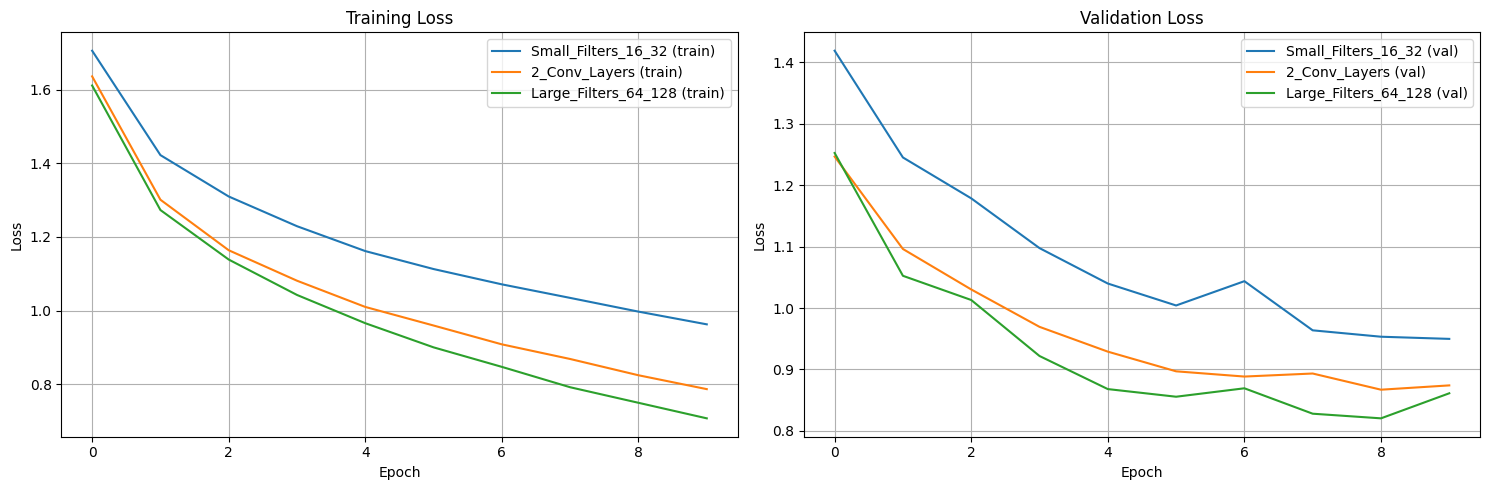


COMPARISON RESULTS
               Model  Test Accuracy  Test Loss  F1-Macro
 Small_Filters_16_32         0.6737     0.9423    0.6728
       2_Conv_Layers         0.6968     0.8760    0.6965
Large_Filters_64_128         0.7098     0.8824    0.7065


,Model,Test Accuracy,Test Loss,F1-Macro
0,Small_Filters_16_32,0.6737,0.942250,0.672799
1,2_Conv_Layers,0.6968,0.875953,0.696530
2,Large_Filters_64_128,0.7098,0.882370,0.706525


In [10]:
print("\n" + "="*80)
print("EKSPERIMEN 2: PENGARUH BANYAK FILTER PER LAYER KONVOLUSI")
print("="*80)

# Model dengan filter kecil
model_small_filters = experiments.create_base_model(
    conv_layers=2, 
    filters_per_layer=[16, 32], 
    kernel_sizes=[(3,3), (3,3)]
)
experiments.train_model(model_small_filters, "Small_Filters_16_32", epochs=10)

# Model dengan filter medium (sudah ada dari experiment sebelumnya)
# model_medium_filters = "2_Conv_Layers" 

# Model dengan filter besar
model_large_filters = experiments.create_base_model(
    conv_layers=2, 
    filters_per_layer=[64, 128], 
    kernel_sizes=[(3,3), (3,3)]
)
experiments.train_model(model_large_filters, "Large_Filters_64_128", epochs=10)

experiments.plot_training_history(["Small_Filters_16_32", "2_Conv_Layers", "Large_Filters_64_128"])
experiments.compare_results(["Small_Filters_16_32", "2_Conv_Layers", "Large_Filters_64_128"])

# 3. Pengaruh ukuran filter per layer konvolusi


EKSPERIMEN 3: PENGARUH UKURAN FILTER PER LAYER KONVOLUSI

Training Kernel_5x5


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 579,402 (2.21 MB)

 Trainable params: 579,402 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - accuracy: 0.3178 - loss: 1.8589 - val_accuracy: 0.5317 - val_loss: 1.3148
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 28ms/step - accuracy: 0.5096 - loss: 1.3680 - val_accuracy: 0.5996 - val_loss: 1.1180
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5764 - loss: 1.1949 - val_accuracy: 0.6315 - val_loss: 1.0408
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.6175 - loss: 1.0906 - val_accuracy: 0.6352 - val_loss: 1.0549
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.6491 - loss: 0.9901 - val_accuracy: 0.6700 - val_loss: 0.9425
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.6741 - loss: 0.9195 - val_accuracy: 0.6748 - val_loss: 0.9343
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6904 - loss: 0.8613 - val_accuracy: 0.6854 - val_loss: 0.9200
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.7144 -

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 548,938 (2.09 MB)

 Trainable params: 548,938 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.2970 - loss: 1.8968 - val_accuracy: 0.5042 - val_loss: 1.3967
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.4810 - loss: 1.4479 - val_accuracy: 0.5593 - val_loss: 1.2617
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.5348 - loss: 1.3033 - val_accuracy: 0.6017 - val_loss: 1.1434
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - accuracy: 0.5779 - loss: 1.1939 - val_accuracy: 0.6196 - val_loss: 1.0897
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.6061 - loss: 1.1188 - val_accuracy: 0.6292 - val_loss: 1.0592
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - accuracy: 0.6280 - loss: 1.0488 - val_accuracy: 0.6401 - val_loss: 1.0355
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 34s 27ms/step - accuracy: 0.6470 - loss: 0.9941 - val_accuracy: 0.6397 - val_loss: 1.0310
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step - accuracy: 0.6606 -

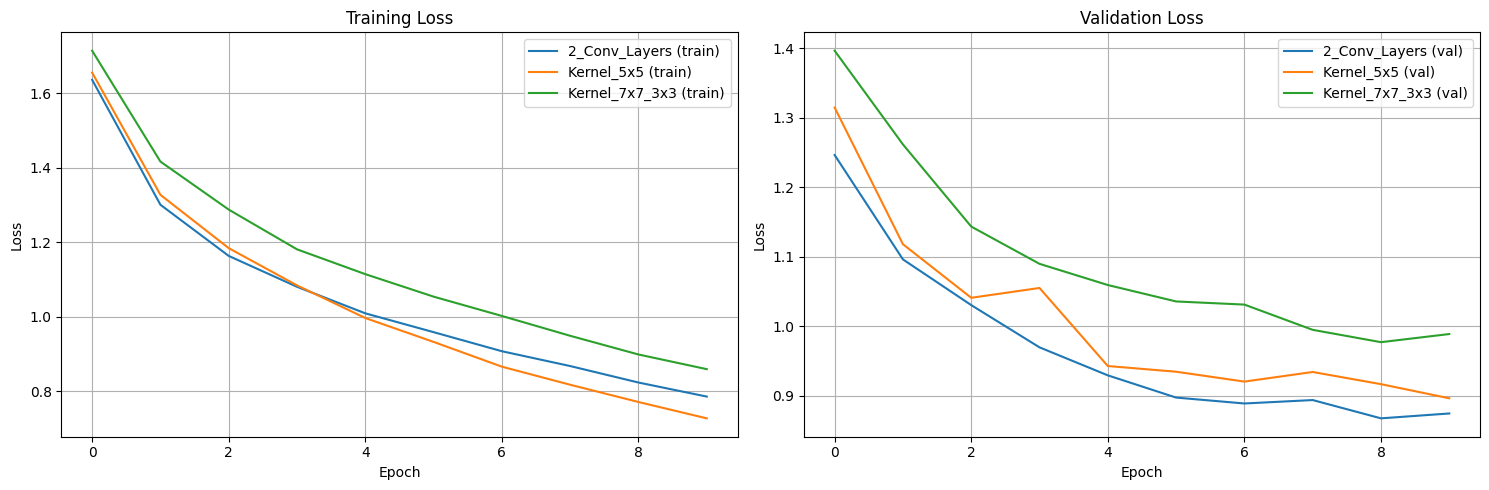


COMPARISON RESULTS
         Model  Test Accuracy  Test Loss  F1-Macro
 2_Conv_Layers         0.6968     0.8760    0.6965
    Kernel_5x5         0.6905     0.9138    0.6897
Kernel_7x7_3x3         0.6644     0.9994    0.6627


,Model,Test Accuracy,Test Loss,F1-Macro
0,2_Conv_Layers,0.6968,0.875953,0.696530
1,Kernel_5x5,0.6905,0.913799,0.689721
2,Kernel_7x7_3x3,0.6644,0.999423,0.662701


In [11]:
print("\n" + "="*80)
print("EKSPERIMEN 3: PENGARUH UKURAN FILTER PER LAYER KONVOLUSI")
print("="*80)

# Model dengan kernel 3x3 (sudah ada)
# model_kernel_3x3 = "2_Conv_Layers"

# Model dengan kernel 5x5
model_kernel_5x5 = experiments.create_base_model(
    conv_layers=2, 
    filters_per_layer=[32, 64], 
    kernel_sizes=[(5,5), (5,5)]
)
experiments.train_model(model_kernel_5x5, "Kernel_5x5", epochs=10)

# Model dengan kernel 7x7
model_kernel_7x7 = experiments.create_base_model(
    conv_layers=2, 
    filters_per_layer=[32, 64], 
    kernel_sizes=[(7,7), (3,3)]
)
experiments.train_model(model_kernel_7x7, "Kernel_7x7_3x3", epochs=10)

experiments.plot_training_history(["2_Conv_Layers", "Kernel_5x5", "Kernel_7x7_3x3"])
experiments.compare_results(["2_Conv_Layers", "Kernel_5x5", "Kernel_7x7_3x3"])

# 4. Pengaruh jenis pooling layer yang digunakan


EKSPERIMEN 4: PENGARUH JENIS POOLING LAYER

Training Average_Pooling


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 16, 16, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 8, 8, 64)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,098 (2.08 MB)

 Trainable params: 545,098 (2.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.3046 - loss: 1.8836 - val_accuracy: 0.5098 - val_loss: 1.3563
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.4894 - loss: 1.4169 - val_accuracy: 0.5633 - val_loss: 1.2163
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.5463 - loss: 1.2580 - val_accuracy: 0.6237 - val_loss: 1.0898
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.5894 - loss: 1.1492 - val_accuracy: 0.6403 - val_loss: 1.0354
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 31s 25ms/step - accuracy: 0.6128 - loss: 1.0896 - val_accuracy: 0.6598 - val_loss: 0.9748
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.6294 - loss: 1.0340 - val_accuracy: 0.6734 - val_loss: 0.9397
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.6544 - loss: 0.9696 - val_accuracy: 0.6788 - val_loss: 0.9308
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.6700 -

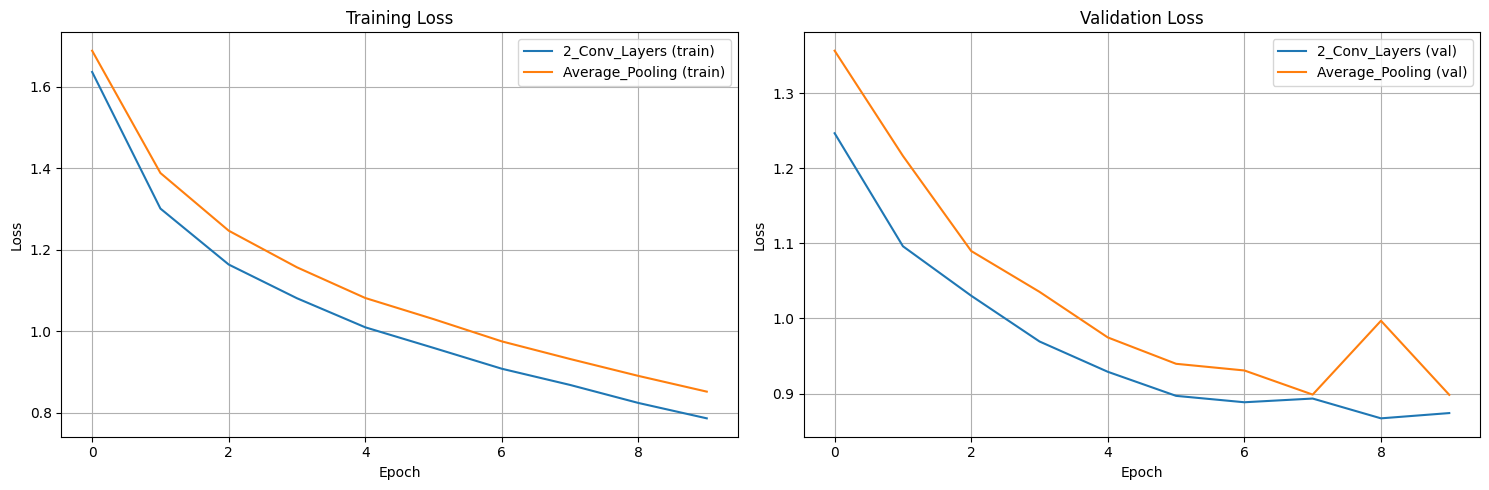


COMPARISON RESULTS
          Model  Test Accuracy  Test Loss  F1-Macro
  2_Conv_Layers         0.6968     0.8760    0.6965
Average_Pooling         0.6889     0.9054    0.6826


,Model,Test Accuracy,Test Loss,F1-Macro
0,2_Conv_Layers,0.6968,0.875953,0.696530
1,Average_Pooling,0.6889,0.905372,0.682634


In [12]:
print("\n" + "="*80)
print("EKSPERIMEN 4: PENGARUH JENIS POOLING LAYER")
print("="*80)

# Model dengan Max Pooling (sudah ada)
# model_max_pooling = "2_Conv_Layers"

# Model dengan Average Pooling
model_avg_pooling = experiments.create_base_model(
    conv_layers=2, 
    filters_per_layer=[32, 64], 
    kernel_sizes=[(3,3), (3,3)],
    pooling_type='average'
)
experiments.train_model(model_avg_pooling, "Average_Pooling", epochs=10)

experiments.plot_training_history(["2_Conv_Layers", "Average_Pooling"])
experiments.compare_results(["2_Conv_Layers", "Average_Pooling"])

# Model Terbaik untuk From Scratch Implementation

In [13]:
print("\n" + "="*80)
print("MEMBUAT MODEL TERBAIK UNTUK FROM SCRATCH IMPLEMENTATION")
print("="*80)

best_model_name = max(experiments.results.keys(), 
                     key=lambda x: experiments.results[x]['f1_macro'])
best_f1 = experiments.results[best_model_name]['f1_macro']

print(f"Best model: {best_model_name} (F1-Macro: {best_f1:.4f})")
print(f"Re-training {best_model_name} with more epochs...")

if "1_Conv" in best_model_name:
    best_model = experiments.create_base_model(conv_layers=1, filters_per_layer=[32])
elif "3_Conv" in best_model_name:
    best_model = experiments.create_base_model(conv_layers=3, filters_per_layer=[32, 64, 128])
elif "Small_Filters" in best_model_name:
    best_model = experiments.create_base_model(conv_layers=2, filters_per_layer=[16, 32])
elif "Large_Filters" in best_model_name:
    best_model = experiments.create_base_model(conv_layers=2, filters_per_layer=[64, 128])
elif "Kernel_5x5" in best_model_name:
    best_model = experiments.create_base_model(conv_layers=2, filters_per_layer=[32, 64], kernel_sizes=[(5,5), (5,5)])
elif "Kernel_7x7" in best_model_name:
    best_model = experiments.create_base_model(conv_layers=2, filters_per_layer=[32, 64], kernel_sizes=[(7,7), (3,3)])
elif "Average_Pooling" in best_model_name:
    best_model = experiments.create_base_model(conv_layers=2, filters_per_layer=[32, 64], pooling_type='average')
else:
    best_model = experiments.create_base_model(conv_layers=2, filters_per_layer=[32, 64])

final_result = experiments.train_model(best_model, "Final_Best_Model", epochs=20)

best_model.save('best_cnn_model.h5')
print("Model saved as 'best_cnn_model.h5'")


MEMBUAT MODEL TERBAIK UNTUK FROM SCRATCH IMPLEMENTATION
Best model: 3_Conv_Layers (F1-Macro: 0.7143)
Re-training 3_Conv_Layers with more epochs...

Training Final_Best_Model


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.3100 - loss: 1.8521 - val_accuracy: 0.5354 - val_loss: 1.2985
Epoch 2/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - accuracy: 0.5305 - loss: 1.3210 - val_accuracy: 0.6199 - val_loss: 1.0796
Epoch 3/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.6106 - loss: 1.1041 - val_accuracy: 0.6656 - val_loss: 0.9576
Epoch 4/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 29s 23ms/step - accuracy: 0.6522 - loss: 0.9887 - val_accuracy: 0.6902 - val_loss: 0.8765
Epoch 5/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.6871 - loss: 0.8849 - val_accuracy: 0.7064 - val_loss: 0.8448
Epoch 6/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.7134 - loss: 0.8121 - val_accuracy: 0.7174 - val_loss: 0.8164
Epoch 7/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.7369 - loss: 0.7515 - val_accuracy: 0.7340 - val_loss: 0.7859
Epoch 8/20
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - accuracy: 0.7554 -

Test Accuracy: 0.7413
Test Loss: 1.0388
F1-Macro Score: 0.7403
Model saved as 'best_cnn_model.h5'


# 5. Forward Propagation: Keras Vs From Scratch

In [ ]:
keras_model = keras.models.load_model('best_cnn_model.h5')

cnn_scratch = CNNFromScratch()
print("Loading Keras weights to from-scratch implementation...")
cnn_scratch.load_from_keras(keras_model)

test_sample_size = 100
x_test_sample = x_test[:test_sample_size]
y_test_sample = y_test[:test_sample_size]

print(f"\nTesting on {test_sample_size} samples...")

print("Keras prediction...")
keras_pred_probs = keras_model.predict(x_test_sample, verbose=0)
keras_pred_classes = np.argmax(keras_pred_probs, axis=1)
keras_f1 = f1_score(y_test_sample, keras_pred_classes, average='macro')

print("From scratch prediction...")
try:
    scratch_pred_probs = cnn_scratch.predict_proba(x_test_sample, batch_size=32)
    scratch_pred_classes = cnn_scratch.predict(x_test_sample, batch_size=32)
    scratch_f1 = f1_score(y_test_sample, scratch_pred_classes, average='macro')
    
    prob_diff = np.mean(np.abs(keras_pred_probs - scratch_pred_probs))
    agreement = np.mean(keras_pred_classes == scratch_pred_classes)
    
    print(f"\nCOMPARISON RESULTS:")
    print(f"="*40)
    print(f"Keras Model:")
    print(f"  Accuracy: {np.mean(keras_pred_classes == y_test_sample):.4f}")
    print(f"  F1-Score: {keras_f1:.6f}")
    print(f"")
    print(f"From Scratch Model:")
    print(f"  Accuracy: {np.mean(scratch_pred_classes == y_test_sample):.4f}")
    print(f"  F1-Score: {scratch_f1:.6f}")
    print(f"")
    print(f"Comparison:")
    print(f"  Prediction Agreement: {agreement:.6f} ({agreement*100:.2f}%)")
    print(f"  Avg Probability Difference: {prob_diff:.6f}")
    print(f"  F1-Score Difference: {abs(keras_f1 - scratch_f1):.6f}")
    
except Exception as e:
    print(f"Error in from scratch implementation: {e}")

Loading Keras weights to from-scratch implementation...
Memuat model Keras ke implementasi from scratch...
Memproses layer 0: Conv2D
Memproses layer 1: MaxPooling2D
Memproses layer 2: Conv2D
Memproses layer 3: MaxPooling2D
Memproses layer 4: Conv2D
Memproses layer 5: MaxPooling2D
Memproses layer 6: Flatten
Memproses layer 7: Dense
Memproses layer 8: Dropout
Memproses layer 9: Dense
Model berhasil dimuat dengan 9 layer

Testing on 100 samples...
Keras prediction...
From scratch prediction...

COMPARISON RESULTS:
Keras Model:
  Accuracy: 0.7600
  F1-Score: 0.734505

From Scratch Model:
  Accuracy: 0.7600
  F1-Score: 0.734505

Comparison:
  Prediction Agreement: 1.000000 (100.00%)
  Avg Probability Difference: 0.000000
  F1-Score Difference: 0.000000
